In [ ]:
# MISC USING


In [1]:
# Uncomment below if running NB in Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


# General Imports
import os 
import numpy as np
import pandas as pd
import time
from dask import dataframe as dd


# Filenames/Categories for Files in Amazon Data Dir
data_files = ['All_Beauty.csv', 'Appliances.csv', 'Arts_Crafts_and_Sewing.csv', 'Automotive.csv', 'Books.csv', 'CDs_and_Vinyl.csv'
            , 'Cell_Phones_and_Accessories.csv', 'Clothing_Shoes_and_Jewelry.csv', 'Digital_Music.csv', 'Electronics.csv'
            , 'Gift_Cards.csv', 'Grocery_and_Gourmet_Food.csv', 'Home_and_Kitchen.csv', 'Industrial_and_Scientific.csv'
            , 'Kindle_Store.csv', 'Magazine_Subscriptions.csv', 'Luxury_Beauty.csv', 'Movies_and_TV.csv', 'Musical_Instruments.csv'
            , 'Office_Products.csv', 'Patio_Lawn_and_Garden.csv', 'Pet_Supplies.csv', 'Prime_Pantry.csv', 'Software.csv'
            , 'Sports_and_Outdoors.csv', 'Tools_and_Home_Improvement.csv', 'Toys_and_Games.csv', 'Video_Games.csv', 'Fashion.csv']
    #29 Product Categories in Total

# Currently config for CKG's Path, add new user paths below
#amz_dir_path = "/content/drive/MyDrive/Gini Spectral Fourier Data Quality project/Amazon Reviews - CKG/" #drive path
amz_dir_path = "/Volumes/GoogleDrive/.shortcut-targets-by-id/1HK4IIdQ8uwDV5XhlWPEB0s6mbi3Ai9Pl/Gini Spectral Fourier Data Quality project/Amazon Reviews - CKG/" #local path


# cd to Amazon Directory
os.chdir(amz_dir_path)
os.listdir()

['FetchData.ipynb',
 'Data',
 'AmazonData-EDA.ipynb',
 'FFT-Notes.ipynb',
 'Amazon_Reviews.csv',
 '.DS_Store',
 'GiniCalculation.ipynb',
 'Ratings.csv',
 'ProductCategory.csv',
 'GiniDraft.ipynb']

**Notes**

After aggregated the data (based on the ProductCategory & Ratings for each date), we were able to cut down on the file size of the RAW data drastically, now both dataframes should fit into memory and work with Pandas



*Original Dataset*

[Amazon_Reviews.csv]() dims = (203,334,833 x 3) @ 6.94 GB

<BR>


[Ratings.csv]() dims = (3,288 x 3) @ 330 KB -- Cols = [datetime, rating, count] 
- datetime = date of ratings
- rating = what rating was given (1 to 5 stars)
- count_rating = count of that category of rating given for that date


[Product_Categories.csv]() dims = (3,288 x 3) @ 3.9 MB -- Cols = [datetime, product_category, count]    
- datetime = date of ratings
- product_category = which of the 29 categories that product belonged to
- count = count of that number of ratings that category recieved for the date

In [2]:
# Read in `Ratings.csv`

ratings_csv = os.path.join(amz_dir_path, "Ratings.csv")
df_ratings = pd.read_csv(ratings_csv, dtype={'rating': 'str', 'datetime':'str', 'count':'int'}, parse_dates=['datetime']) #may need to specify column dtype with dict like so
df_ratings

,datetime,rating,count
0,2009-03-11,5.0,3934
1,2009-03-11,4.0,1419
2,2009-03-11,3.0,606
3,2009-03-11,1.0,567
4,2009-03-11,2.0,355
...,...,...,...
16435,2017-12-13,5.0,60215
16436,2017-12-13,4.0,11950
16437,2017-12-13,1.0,9416
16438,2017-12-13,3.0,6593


In [35]:
# Read in `ProductCategory.csv`

prod_cat_csv = os.path.join(amz_dir_path, "ProductCategory.csv")
df_product = pd.read_csv(prod_cat_csv, dtype={'product_category': 'str', 'datetime':'str', 'count':'int'}, parse_dates=['datetime']) #may need to specify column dtype with dict like so
df_product

,datetime,product_category,count
0,2009-03-11,books,2581
1,2009-03-11,electronics,1127
2,2009-03-11,movies_and_tv,528
3,2009-03-11,cds_and_vinyl,527
4,2009-03-11,clothing_shoes_and_jewelry,355
...,...,...,...
95347,2009-09-25,fashion,0
95348,2009-10-10,fashion,0
95349,2010-03-27,fashion,0
95350,2010-07-31,fashion,0


# Gini Calculation 


References: 
- Basic Implementation in NP: https://github.com/oliviaguest/gini
- Gini's for NN Activations: https://neuroplausible.com/gini

- **END ALL POST - STACKOVERFLOW** https://stackoverflow.com/questions/48981516/weighted-gini-coefficient-in-python

In [6]:
# StackOverflow Example - https://stackoverflow.com/questions/48981516/weighted-gini-coefficient-in-python

def gini(x, weights=None): #this function works, just apply it to the counts in both datasets!
    if weights is None: #weights nonessential, counts function as weights in Aggregated Amazon Data! (specific feature of this dataset, the weights could be the counts for diff data)
        weights = np.ones_like(x)
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum() #mean absolute deviation
    rmad = mad / np.average(x, weights=weights) #relative mean absolute deviation 
    return 0.5 * rmad #half the RMAD is mathematically equivalent to the typical economics Gini calculation

#### Create Dicts for Gini Calc & Iter

based on unique days & the list of associated counts vals

In [36]:
# Apply for Ratings
ratings_dict = {'DATE':[], "TOTAL":[], "GINI":[]}

ratings_dict["DATE"] = df_ratings["datetime"].unique()

for date in ratings_dict["DATE"]:
    df = df_ratings[df_ratings["datetime"] == date]
    total_ratings = list(df["count"])
    ratings_dict["TOTAL"].append(total_ratings)


# Apply for Product Category
product_dict = {'DATE':[], "TOTAL":[], "GINI":[]}

product_dict["DATE"] = df_product["datetime"].unique()

for date in product_dict["DATE"]:
    df = df_product[df_product["datetime"] == date]
    count_prod_reviews = list(df["count"])
    product_dict["TOTAL"].append(count_prod_reviews)


In [ ]:
ratings_dict

#### GroupBy for Daily Totals

What needs to be done to make below good

Just pass in the counts, these are sufficient to compute the Gini Algorithm (each val is i and j and take absolute diff for all pairs i & j, then take mean for MAD)

Wikipedia Article (specific section) was paradigm shifting, read "An alternative approach to define the Gini coefficient..." in the definition section [here](https://en.wikipedia.org/wiki/Gini_coefficient)

In [37]:
# Apply Gini Function to Ratings & Product Dict

for values in ratings_dict["TOTAL"]:
    gc = gini(values)
    ratings_dict["GINI"].append(gc)

for values in product_dict["TOTAL"]:
    gc = gini(values)
    product_dict["GINI"].append(gc)

In [45]:
print(f" Ratings Avg Gini = {np.mean(ratings_dict['GINI']):.4f}\nProducts Avg Gini = {np.mean(product_dict['GINI']):.4f}")

 Ratings Avg Gini = 0.4882
Products Avg Gini = 0.6580


In [46]:
# Convert Dicts to DFs and Write to CSVs

r = pd.DataFrame.from_dict(ratings_dict)
p = pd.DataFrame.from_dict(product_dict)

r.to_csv("Ratings-Ginis.csv", index=False)
p.to_csv("Products-Ginis.csv", index=False)

In [12]:
import pandas as pd 

r = pd.read_csv("Ratings-Ginis.csv", dtype={'TOTAL': 'str', 'datetime':'str'}, parse_dates=['DATE'])
p = pd.read_csv("Products-Ginis.csv", dtype={'TOTAL': 'str', 'datetime':'str'}, parse_dates=['DATE'])

In [3]:
r


,DATE,TOTAL,GINI
0,2009-03-11,"[3934, 1419, 606, 567, 355]",0.465630
1,2009-11-01,"[5222, 1811, 724, 676, 512]",0.471996
2,2009-12-02,"[4429, 1492, 711, 669, 467]",0.450412
3,2010-02-06,"[10488, 3203, 1301, 1240, 803]",0.500922
4,2011-02-09,"[6262, 1987, 1098, 893, 628]",0.454987
...,...,...,...
3283,2017-07-18,"[162080, 40818, 19402, 16213, 11164]",0.522975
3284,2017-10-23,"[75538, 15711, 9833, 8122, 5529]",0.514610
3285,2017-11-07,"[63393, 13084, 8548, 6602, 4652]",0.515020
3286,2017-11-23,"[27851, 5660, 4540, 3061, 2285]",0.495251


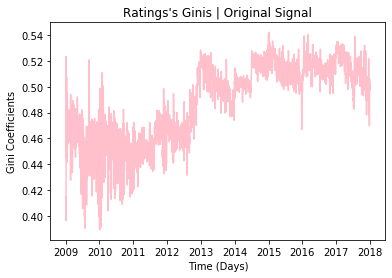

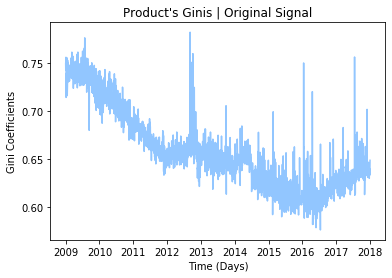

In [21]:
# Plot Gini Coefficients Over Years - https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")


# Ratings -- Need sort the df by date
r = r.sort_values(by=['DATE'])
dates = r["DATE"]
gini_values = r["GINI"]

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Gini Coefficients")
ax.set_title("Ratings's Ginis | Original Signal");
ax.plot(dates, gini_values, color="pink")


# Product Category
p = p.sort_values(by=['DATE'])
dates = p["DATE"]
gini_values = p["GINI"]

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Gini Coefficients")
ax.set_title("Product's Ginis | Original Signal");
ax.plot(dates, gini_values)

**Notes on Graphs**

The Gini values for the product dataset are decreasing over time (in general sans what looks like 7 sporadic peaks) -- due in part to the addition of new categories or the breaking down/diluting of existing ones 

There is a distinct increase in the Ratings Gini values in 2012 to 2013 (this may in part be due to an increase in adoption, as the stock price nearly price doubled over the course of 3 years 2011-2013)


<br>


**KC Notes from 12/14/21**

*on FFT


Amplitude for NP FFT -> to calculate, take Square of Both Coefficents for the Returned value (after applying NP.fft) 


* Not as easy as running FFT transform, take into account the nuances of the FFT: 
    - Drop very first entry (zero item)
    - Take half of what gets returned? 
    - Determine how to scale the amplitudes

Main Idea -- To get something done well, build what exactly you'd like, do not use those out-of-the box implementations

In [6]:
1/.28
1/.14

7.142857142857142